<span style="font-size:3em;">Ch6: Using a neural network to fit the data </span>

In this chapter, we will make some changes to our model architecture: we’re going to
implement a full artificial neural network to solve our temperature-conversion
problem. We’ll continue using our training loop from the last chapter, along with our
Fahrenheit-to-Celsius samples split into training and validation sets. We could start to
use a quadratic model: rewriting model as a quadratic function of its input 

# 6.1 Artificial neurons

The basic building block of these complicated functions is the neuron, as illustrated in
figure 6.2. At its core, it is nothing but a linear transformation of the input (for example, multiplying the input by a number [the weight] and adding a constant [the bias])
followed by the application of a fixed nonlinear function (referred to as the activation
function).

 Mathematically, we can write this out as o = f(w * x + b), with x as our input, w our
weight or scaling factor, and b as our bias or offset. f is our activation function.


## 6.1.1 Composing a multilayer network
A multilayer neural network is made up of a composition of functions:

x_1 = f(w_0 * x + b_0)

x_2 = f(w_1 * x_1 + b_1)

...

y = f(w_n * x_n + b_n)

where the output of a layer of neurons is used as an input for the following layer

## 6.1.2 Understanding the error function

 Our linear model and
error-squared loss function had a convex error curve with a singular, clearly defined
minimum. If we were to use other methods, we could solve for the parameters minimizing the error function automatically and definitively. That means that our parameter updates were attempting to estimate that singular correct answer as best they could.

 Neural networks do not have that same property of a convex error surface, even
when using the same error-squared loss function! There’s no single right answer for
each parameter we’re attempting to approximate. Instead, we are trying to get all of
the parameters, when acting in concert, to produce a useful output. Since that useful
output is only going to approximate the truth, there will be some level of imperfection.

 A big part of the reason neural networks have non-convex error surfaces is due to
the activation function. The ability of an ensemble of neurons to approximate a very
wide range of useful functions depends on the combination of the linear and nonlinear behavior inherent to each neuron. 


## 6.1.3 All we need is activation

 The activation
function plays two important roles:
-  In the inner parts of the model, it allows the output function to have different
slopes at different values—something a linear function by definition cannot do.
By trickily composing these differently sloped parts for many outputs, neural
networks can approximate arbitrary functions


- At the last layer of the network, it has the role of concentrating the outputs of
the preceding linear operation into a given range.

## 6.1.4 More activation functions
- Tanh
- Sigmoid
- ReLU
- PreLU
- Leaky ReLU
- Softplus
- HardTanh
- And many more

## 6.1.5 Choosing the best activation function

Activation functions are curious, because with such a wide variety of proven successful
ones, it’s clear that there are few, if any, strict
requirements. As such, we’re going to discuss some generalities about activation functions that can probably be trivially disproved in the specific.

<b>By definition activation functions  are:</b>
- Are nonlinear. Repeated applications of (w*x+b) without an activation function
results in a function of the same (affine linear) form. The nonlinearity allows
the overall network to approximate more complex functions.


- Are differentiable, so that gradients can be computed through them. Point discontinuities, as we can see in Hardtanh or ReLU, are fine.

Without these characteristics, the network either falls back to being a linear model or
becomes difficult to train.

<b>The following are True for the functions:</b>
- They have at least one sensitive range, where nontrivial changes to the input
result in a corresponding nontrivial change to the output. This is needed for
training.


- Many of them have an insensitive (or saturated) range, where changes to the
input result in little or no change to the output


<b> Often (but far from universally so), the activation function will have at least one of
these:</b>
- A lower bound that is approached (or met) as the input goes to negative infinity


- A similar-but-inverse upper bound for positive infinity


Thinking of what we know about how backpropagation works, we can figure out that
the errors will propagate backward through the activation more effectively when the
inputs are in the response range, while errors will not greatly affect neurons for which the input is saturated (since the gradient will be close to zero, due to the flat area
around the output)

Put together, all this results in a pretty powerful mechanism: we’re saying that in a
network built out of linear + activation units, when different inputs are presented to
the network,

1.  different units will respond in different ranges for the same inputs
2. the errors associated with those inputs will primarily affect the neurons operating in the sensitive range, leaving other units more or less unaffected by the learning process

In addition, thanks to the fact that derivatives of the activation with
respect to its inputs are often close to 1 in the sensitive range, estimating the parameters of the linear transformation through gradient descent for the units that operate
in that range will look a lot like the linear fit we have seen previously.

 Different combinations of units will respond to inputs in different ranges, and those parameters for
those units are relatively easy to optimize through gradient descent, since learning will
behave a lot like that of a linear function until the output saturates. 

## 6.1.6 What learning means for a neural network
 What makes using
deep neural networks so attractive is that it saves us from worrying too much about the
exact function that represents our data—whether it is quadratic, piecewise polynomial, or something else. With a deep neural network model, we have a universal
approximator and a method to estimate its parameters. This approximator can be customized to our needs, in terms of model capacity and its ability to model complicated
input/output relationships, just by composing simple building blocks. 

# 6.2 The PyTorch nn module

 PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It
contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance (such building
blocks are often referred to as layers in other frameworks). A PyTorch module is a
Python class deriving from the nn.Module base class. A module can have one or more
Parameter instances as attributes, which are tensors whose values are optimized
during the training process (think w and b in our linear model). A module can also
have one or more submodules (subclasses of nn.Module) as attributes, and it will be
able to track their parameters as well.

<b>NOTE:</b> The submodules must be top-level attributes, not buried inside list or
dict instances! Otherwise, the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model
requires a list or dict of submodules, PyTorch provides nn.ModuleList and
nn.ModuleDict.


Unsurprisingly, we can find a subclass of nn.Module called nn.Linear, which applies
an affine transformation to its input (via the parameter attributes weight and bias)
and is equivalent to what we implemented earlier in our thermometer experiments

## 6.2.1 Using __call__ rather than forward

All PyTorch-provided subclasses of nn.Module have their<b> __ call __ </b>method defined.
This allows us to instantiate an nn.Linear and call it as if it was a function, like so

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [22]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

In [23]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([5, 1, 3, 8, 6, 2, 7, 4, 0]), tensor([ 9, 10]))

In [24]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [25]:
linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[-2.8320],
        [-3.1391]], grad_fn=<AddmmBackward>)

Calling an instance of nn.Module with a set of arguments ends up calling a method
named forward with the same arguments. The forward method is what executes the
forward computation, while __call__ does other rather important chores before and
after calling forward. So, it is technically possible to call forward directly, and it will
produce the same output as __call__, but this should not be done from user code:

y = model(x) --> Correct

y = model.forward(x) --> Wrong

## 6.2.2 Returning to the linear model

 The constructor to nn.Linear accepts three arguments: the
number of input features, the number of output features, and whether the linear
model includes a bias or not (defaults to true)

In [26]:
linear_model(t_un_val)

tensor([[-2.8320],
        [-3.1391]], grad_fn=<AddmmBackward>)

The number of features in our case just refers to the size of the input and the output
tensor for the module, so 1 and 1. We have an instance of nn.Linear with one input and one output feature. That
only requires one weight and one bias:

In [27]:
linear_model.weight

Parameter containing:
tensor([[-0.3838]], requires_grad=True)

In [28]:
linear_model.bias

Parameter containing:
tensor([-0.5137], requires_grad=True)

In [30]:
#Can call the model as such
x = torch.ones(1)
linear_model(x)

tensor([-0.8975], grad_fn=<AddBackward0>)

 Modules expect the zeroth dimension of the input to be the number of samples in the batch.
 Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model

In [31]:
x = torch.ones(10,1)
linear_model(x)

tensor([[-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975],
        [-0.8975]], grad_fn=<AddmmBackward>)

The reason we want to do this batching is multifaceted. 
- One big motivation is to make
sure the computation we’re asking for is big enough to saturate the computing
resources we’re using to perform the computation. 

- GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle.
By providing batches of inputs, the calculation can be spread across the otherwise-idle
units, which means the batched results come back just as quickly as a single result
would. 

- Another benefit is that some advanced models use statistical information from
the entire batch, and those statistics get better with larger batch sizes

In [33]:
#We can see that the unsqueeze added a batch size dimension
t_c.shape,t_u.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

In [35]:
#Now lets update training code
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), #adds our models parameters to the optimizer
                     lr=1e-2)

In [37]:
#Now we can look use parameters method to look at all parameters in a model
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.2679]], requires_grad=True),
 Parameter containing:
 tensor([-0.1805], requires_grad=True)]

This call recurses into submodules defined in the module’s init constructor and
returns a flat list of all parameters encountered, so that we can conveniently pass it to
the optimizer constructor as we did previously. This allows us to easily step through the model and update parameters accordingly

In [39]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        
        loss_val = loss_fn(t_p_val, t_c_val)
        
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
            f" Validation loss {loss_val.item():.4f}")

It hasn’t changed practically at all, except that now we don’t pass params explicitly to
model since the model itself holds its Parameters internally.
 There’s one last bit that we can leverage from torch.nn: the loss. Indeed, nn comes
with several common loss functions, among them nn.MSELoss.  Loss functions
in nn are still subclasses of nn.Module, so we will create an instance and call it as a
function.

In [40]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 100.4855, Validation loss 187.2295
Epoch 1000, Training loss 3.3979, Validation loss 4.2125
Epoch 2000, Training loss 2.8067, Validation loss 3.6172
Epoch 3000, Training loss 2.7946, Validation loss 3.5611

Parameter containing:
tensor([[5.3307]], requires_grad=True)
Parameter containing:
tensor([-17.0600], requires_grad=True)


# 6.3 Finally a neural network
 There’s one last step left to take: replacing our linear model with a neural network
as our approximating function. We said earlier that using a neural network will not
result in a higher-quality model, since the process underlying our calibration problem
was fundamentally linear

## 6.3.1 Replacing the linear model
We are going to keep everything else fixed, including the loss function, and only redefine model. Let’s build the simplest possible neural network: a linear module, followed
by an activation function, feeding into another linear module.

__nn provides a simple way to concatenate modules through the nn.Sequential
container__

In [41]:
seq_model = nn.Sequential(
            nn.Linear(1,13),
            nn.Tanh(),
            nn.Linear(13,1))

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

## 6.3.2 Inspecting the parameters
Calling model.parameters() will collect weight and bias from both the first and second linear modules.

In [43]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call model.backward(),
all parameters are populated with their grad, and the optimizer then updates their values accordingly during the optimizer.step() call.  A few notes on parameters of nn.Modules. When inspecting parameters of a model
made up of several submodules, it is handy to be able to identify parameters by name.
There’s a method for that, called named_parameters

In [44]:
for name, param in seq_model.named_parameters():
    print(name,param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in Sequential is just the ordinal with which the module
appears in the arguments. Interestingly, Sequential also accepts an OrderedDict, in which we can name each module passed to Sequential

In [45]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
        ('hidden_linear', nn.Linear(1, 8)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(8, 1))
]))

In [47]:
#allows us to get more explanatory names
for name, param in seq_model.named_parameters():
    print(name,param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


This is more descriptive; but it does not give us more flexibility in the flow of data
through the network, which remains a purely sequential pass-through—the
nn.Sequential is very aptly named. We will see how to take full control of the processing of input data by subclassing nn.Module ourselves in chapter 8.

In [48]:
# We can also access a particular Parameter by using submodules as attributes:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0868], requires_grad=True)

This is useful for inspecting parameters or their gradients: for instance, to monitor
gradients during training, as we did at the beginning of this chapter. Say we want to
print out the gradients of weight of the linear portion of the hidden layer. We can run
the training loop for the new neural network model and then look at the resulting
gradients after the last epoch:

In [49]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 158.9396, Validation loss 300.8373
Epoch 1000, Training loss 5.6530, Validation loss 4.9669
Epoch 2000, Training loss 3.0531, Validation loss 8.1890
Epoch 3000, Training loss 1.7012, Validation loss 3.9538
Epoch 4000, Training loss 1.5439, Validation loss 4.3303
Epoch 5000, Training loss 1.5118, Validation loss 4.5934
output tensor([[15.9374],
        [21.7475]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [21.]])
hidden tensor([[-0.0095],
        [ 0.0093],
        [-0.0046],
        [ 0.0127],
        [ 0.0068],
        [ 0.0518],
        [-0.0073],
        [-0.0023]])


## 6.3.3 Comparing to the linear model
We can also evaluate the model on all of the data and see how it differs from a line:

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

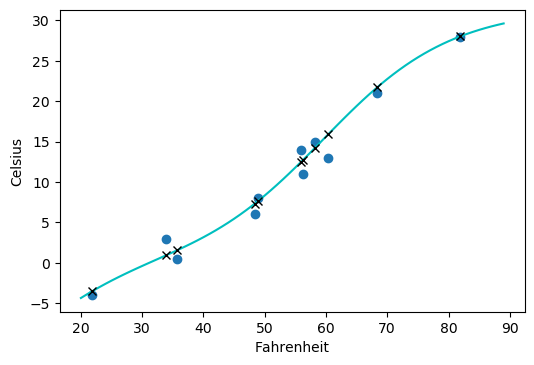

In [51]:
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=100)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(),'kx')

The above graph shows that our model is overfitting